# GRU Model

In [60]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

In [21]:
## read data

clean_data_path ='../data/clean data/combined_data.csv'
combined_df = pd.read_csv(clean_data_path)

In [61]:
combined_df.head()

,userId,movieId,rating,timestamp,title,genres,Action,Adventure,Animation,Children,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Others
0,1,2,3.5,2005-04-02,Jumanji (1995),Adventure|Children|Fantasy,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,29,3.5,2005-04-02,"City of Lost Children, The (Cité des enfants p...",Adventure|Drama|Fantasy|Mystery|Sci-Fi,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
2,1,32,3.5,2005-04-02,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0
3,1,47,3.5,2005-04-02,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,1,50,3.5,2005-04-02,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [35]:
print(combined_df.columns)

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'Action',
       'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'Others'],
      dtype='object')


In [96]:
model_df = combined_df.copy()

## leave only 'timestamp' and one-hot encoding of genres
## convert timestamp tto ordinal
model_df['timestamp'] = pd.to_datetime(model_df['timestamp']).dt.date
model_df['timestamp_ordinal'] = model_df['timestamp'].apply(lambda x: x.toordinal())

## define features and target
features = model_df.drop(columns=['title', 'rating', 'userId', 'movieId', 'genres', 'timestamp'])
target = model_df['rating']

## normalize the feature set
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [112]:
## function for blocking time series split
def my_blocking_time_series_split(data, n_splits=2, block_size=1):
    n_samples = len(data)
    indices = []
    test_size = n_samples // (n_splits + 1)

    for i in range(n_splits):
        train_end = n_samples - (n_splits - i) * test_size - block_size
        test_start = train_end + block_size
        test_end = test_start + test_size

        train_indices = np.arange(0, train_end)
        test_indices = np.arange(test_start, test_end)
        indices.append((train_indices, test_indices))
    
    return indices

In [98]:
## function for training gru model
def my_gru_model(input_shape, n_units=10):
    model = Sequential()
    model.add(GRU(units=n_units, return_sequences=False, input_shape=input_shape)) 
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model

In [99]:
## functions for compute rmse and its mean and variance

def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def compute_mean_and_variance(rmse_values):
    mean_rmse = np.mean(rmse_values)
    variance_rmse = np.var(rmse_values)
    return mean_rmse, variance_rmse




In [114]:
## !!! THIS PART MAY TAKE UP TO 5 HOURS TO FINISH !!!

## grid for hyperparameter tuning
param_grid = [50,70]

## number of splits for inner and outer split
n_outer_splits = 20
n_inner_splits = 2
block_size = 1
outer_splits = my_blocking_time_series_split(features_scaled, n_splits=n_outer_splits, block_size=block_size)

results = []
final_model = None
train_losses_all = []
test_losses_all = []
rmse_results = []


for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(outer_splits):
    print(f"Outer fold {outer_fold + 1}/{n_outer_splits}")

    X_outer_train, X_outer_test = features_scaled[outer_train_idx], features_scaled[outer_test_idx]
    y_outer_train, y_outer_test = target[outer_train_idx], target[outer_test_idx]

    X_outer_train = X_outer_train.reshape(X_outer_train.shape[0], 1, X_outer_train.shape[1])
    X_outer_test = X_outer_test.reshape(X_outer_test.shape[0], 1, X_outer_test.shape[1])

    ## inner cross-validation for hyperparameter tuning
    best_units = None
    best_loss = np.inf
    for n_units in param_grid:
        inner_splits = my_blocking_time_series_split(X_outer_train, n_splits=n_inner_splits, block_size=block_size)
        inner_losses = []

        for inner_fold, (inner_train_idx, inner_test_idx) in enumerate(inner_splits):
            print(f"  Inner fold {inner_fold + 1}/{n_inner_splits} - Testing with {n_units} GRU units")
            X_inner_train, X_inner_test = X_outer_train[inner_train_idx], X_outer_train[inner_test_idx]
            y_inner_train, y_inner_test = y_outer_train[inner_train_idx], y_outer_train[inner_test_idx]

            model = my_gru_model(input_shape=(X_inner_train.shape[1], X_inner_train.shape[2]), n_units=n_units)
            history = model.fit(X_inner_train, y_inner_train, epochs=5, batch_size=64, verbose=0)
            y_pred_inner = model.predict(X_inner_test).ravel()
            inner_loss = mean_squared_error(y_inner_test, y_pred_inner)
            inner_losses.append(inner_loss)

        avg_inner_loss = np.mean(inner_losses)
        if avg_inner_loss < best_loss:
            best_loss = avg_inner_loss
            best_units = n_units

    print(f"Best number of units: {best_units}")

    ## train the final model with the best hyperparameters
    final_model = my_gru_model(input_shape=(X_outer_train.shape[1], X_outer_train.shape[2]), n_units=best_units)
    history = final_model.fit(X_outer_train, y_outer_train, epochs=5, batch_size=64, verbose=0)

    ## collect learning curves
    train_losses_all.append(history.history['loss'])

    ## evaluate on outer test set
    y_pred_outer = final_model.predict(X_outer_test).ravel()
    test_loss = mean_squared_error(y_outer_test, y_pred_outer)
    test_losses_all.append(test_loss)

    ## calculate RMSE for the outer test set
    rmse = compute_rmse(y_outer_test, y_pred_outer)
    rmse_results.append(rmse)
    print(f"Test RMSE for outer fold {outer_fold + 1}: {rmse}")



Outer fold 1/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9921/9921 ━━━━━━━━━━━━━━━━━━━━ 5s 472us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9921/9921 ━━━━━━━━━━━━━━━━━━━━ 5s 493us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9921/9921 ━━━━━━━━━━━━━━━━━━━━ 4s 441us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9921/9921 ━━━━━━━━━━━━━━━━━━━━ 5s 462us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 463us/step
Test RMSE for outer fold 1: 1.005717799380462
Outer fold 2/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19842/19842 ━━━━━━━━━━━━━━━━━━━━ 9s 454us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19842/19842 ━━━━━━━━━━━━━━━━━━━━ 9s 442us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19842/19842 ━━━━━━━━━━━━━━━━━━━━ 9s 460us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19842/19842 ━━━━━━━━━━━━━━━━━━━━ 9s 451us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 13s 422us/step
Test RMSE for outer fold 2: 1.0137801956606838
Outer fold 3/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 461us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 13s 442us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 462us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 476us/step
Test RMSE for outer fold 3: 1.0101998279010411
Outer fold 4/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39684/39684 ━━━━━━━━━━━━━━━━━━━━ 18s 456us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39684/39684 ━━━━━━━━━━━━━━━━━━━━ 18s 450us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39684/39684 ━━━━━━━━━━━━━━━━━━━━ 18s 448us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39684/39684 ━━━━━━━━━━━━━━━━━━━━ 18s 453us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 456us/step
Test RMSE for outer fold 4: 1.0035941724865787
Outer fold 5/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49604/49604 ━━━━━━━━━━━━━━━━━━━━ 22s 441us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49604/49604 ━━━━━━━━━━━━━━━━━━━━ 22s 444us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49604/49604 ━━━━━━━━━━━━━━━━━━━━ 23s 454us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49604/49604 ━━━━━━━━━━━━━━━━━━━━ 22s 443us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 458us/step
Test RMSE for outer fold 5: 1.006166248292528
Outer fold 6/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59525/59525 ━━━━━━━━━━━━━━━━━━━━ 27s 447us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59525/59525 ━━━━━━━━━━━━━━━━━━━━ 28s 466us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59525/59525 ━━━━━━━━━━━━━━━━━━━━ 26s 435us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59525/59525 ━━━━━━━━━━━━━━━━━━━━ 27s 452us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 453us/step
Test RMSE for outer fold 6: 1.0004504664106064
Outer fold 7/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69446/69446 ━━━━━━━━━━━━━━━━━━━━ 31s 439us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69446/69446 ━━━━━━━━━━━━━━━━━━━━ 32s 460us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69446/69446 ━━━━━━━━━━━━━━━━━━━━ 32s 458us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69446/69446 ━━━━━━━━━━━━━━━━━━━━ 32s 455us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 455us/step
Test RMSE for outer fold 7: 1.010298499003869
Outer fold 8/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79367/79367 ━━━━━━━━━━━━━━━━━━━━ 35s 441us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79367/79367 ━━━━━━━━━━━━━━━━━━━━ 35s 440us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79367/79367 ━━━━━━━━━━━━━━━━━━━━ 35s 441us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79367/79367 ━━━━━━━━━━━━━━━━━━━━ 36s 449us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 13s 447us/step
Test RMSE for outer fold 8: 0.99174316811228
Outer fold 9/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89287/89287 ━━━━━━━━━━━━━━━━━━━━ 40s 445us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89287/89287 ━━━━━━━━━━━━━━━━━━━━ 40s 443us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89287/89287 ━━━━━━━━━━━━━━━━━━━━ 40s 449us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89287/89287 ━━━━━━━━━━━━━━━━━━━━ 41s 455us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 13s 442us/step
Test RMSE for outer fold 9: 1.0117833857819436
Outer fold 10/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99208/99208 ━━━━━━━━━━━━━━━━━━━━ 45s 448us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99208/99208 ━━━━━━━━━━━━━━━━━━━━ 44s 440us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99208/99208 ━━━━━━━━━━━━━━━━━━━━ 45s 448us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99208/99208 ━━━━━━━━━━━━━━━━━━━━ 45s 449us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 454us/step
Test RMSE for outer fold 10: 0.9978012580291091
Outer fold 11/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109129/109129 ━━━━━━━━━━━━━━━━━━━━ 51s 464us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109129/109129 ━━━━━━━━━━━━━━━━━━━━ 49s 445us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109129/109129 ━━━━━━━━━━━━━━━━━━━━ 50s 456us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


109129/109129 ━━━━━━━━━━━━━━━━━━━━ 50s 460us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 460us/step
Test RMSE for outer fold 11: 1.0181493986697425
Outer fold 12/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119050/119050 ━━━━━━━━━━━━━━━━━━━━ 52s 438us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119050/119050 ━━━━━━━━━━━━━━━━━━━━ 53s 441us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119050/119050 ━━━━━━━━━━━━━━━━━━━━ 53s 444us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


119050/119050 ━━━━━━━━━━━━━━━━━━━━ 54s 453us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 454us/step
Test RMSE for outer fold 12: 0.9999617123459057
Outer fold 13/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128970/128970 ━━━━━━━━━━━━━━━━━━━━ 57s 440us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128970/128970 ━━━━━━━━━━━━━━━━━━━━ 57s 444us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128970/128970 ━━━━━━━━━━━━━━━━━━━━ 58s 449us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128970/128970 ━━━━━━━━━━━━━━━━━━━━ 59s 444us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 455us/step
Test RMSE for outer fold 13: 1.0089249308082404
Outer fold 14/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138891/138891 ━━━━━━━━━━━━━━━━━━━━ 62s 444us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138891/138891 ━━━━━━━━━━━━━━━━━━━━ 63s 449us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138891/138891 ━━━━━━━━━━━━━━━━━━━━ 65s 464us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


138891/138891 ━━━━━━━━━━━━━━━━━━━━ 63s 452us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 454us/step
Test RMSE for outer fold 14: 1.0081995827294725
Outer fold 15/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148812/148812 ━━━━━━━━━━━━━━━━━━━━ 66s 443us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148812/148812 ━━━━━━━━━━━━━━━━━━━━ 67s 448us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148812/148812 ━━━━━━━━━━━━━━━━━━━━ 68s 459us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148812/148812 ━━━━━━━━━━━━━━━━━━━━ 67s 450us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 457us/step
Test RMSE for outer fold 15: 1.000998116359328
Outer fold 16/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158733/158733 ━━━━━━━━━━━━━━━━━━━━ 71s 447us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158733/158733 ━━━━━━━━━━━━━━━━━━━━ 71s 449us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158733/158733 ━━━━━━━━━━━━━━━━━━━━ 72s 454us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


158733/158733 ━━━━━━━━━━━━━━━━━━━━ 73s 458us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 462us/step
Test RMSE for outer fold 16: 1.0125840032017273
Outer fold 17/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168653/168653 ━━━━━━━━━━━━━━━━━━━━ 79s 465us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168653/168653 ━━━━━━━━━━━━━━━━━━━━ 76s 452us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168653/168653 ━━━━━━━━━━━━━━━━━━━━ 77s 457us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


168653/168653 ━━━━━━━━━━━━━━━━━━━━ 77s 456us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 460us/step
Test RMSE for outer fold 17: 0.9973704169769522
Outer fold 18/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178574/178574 ━━━━━━━━━━━━━━━━━━━━ 80s 450us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178574/178574 ━━━━━━━━━━━━━━━━━━━━ 81s 451us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178574/178574 ━━━━━━━━━━━━━━━━━━━━ 81s 455us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178574/178574 ━━━━━━━━━━━━━━━━━━━━ 83s 462us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 463us/step
Test RMSE for outer fold 18: 1.0021896546226137
Outer fold 19/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188495/188495 ━━━━━━━━━━━━━━━━━━━━ 85s 451us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188495/188495 ━━━━━━━━━━━━━━━━━━━━ 85s 448us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188495/188495 ━━━━━━━━━━━━━━━━━━━━ 88s 465us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


188495/188495 ━━━━━━━━━━━━━━━━━━━━ 87s 462us/step
Best number of units: 50


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 455us/step
Test RMSE for outer fold 19: 0.9976067072523935
Outer fold 20/20
  Inner fold 1/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198416/198416 ━━━━━━━━━━━━━━━━━━━━ 89s 448us/step
  Inner fold 2/2 - Testing with 50 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198416/198416 ━━━━━━━━━━━━━━━━━━━━ 92s 461us/step
  Inner fold 1/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198416/198416 ━━━━━━━━━━━━━━━━━━━━ 90s 454us/step
  Inner fold 2/2 - Testing with 70 GRU units


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198416/198416 ━━━━━━━━━━━━━━━━━━━━ 91s 459us/step
Best number of units: 70


c:\Users\13062\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29763/29763 ━━━━━━━━━━━━━━━━━━━━ 14s 467us/step
Test RMSE for outer fold 20: 1.0096993863626484


In [159]:
## function for ploting inner training losses

def plot_inner_training_losses(losses_list):
    n_folds = len(losses_list)
    epochs = len(losses_list[0])
    

    training_losses_np = np.array(losses_list)
    ## get average training loss across folds
    avg_training_loss = np.mean(training_losses_np, axis=0)
    
    ## plot each fold's training loss
    for i, fold_losses in enumerate(losses_list):
        plt.plot(range(epochs), fold_losses, label=f'Loss Fold {i+1}')
    
    ## plot the average
    plt.plot(range(epochs), avg_training_loss, label='Average Training Loss', marker='o', color='black', linewidth=2)
    
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['1', '2', '3', '4', '5'])
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Inner Training Losses with Average')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

In [194]:
## plot for learning curves

def plot_learning_curves(train_losses, test_losses):
    n_outer_folds = len(train_losses)
    n_inner_folds = len(train_losses[0])
    
    ## calculate the average inner fold losses for each outer fold
    outer_fold_averages = []
    for outer_fold_losses in train_losses:
        avg_loss = np.mean(outer_fold_losses, axis=0)
        outer_fold_averages.append(avg_loss)
    
    plt.plot(outer_fold_averages, marker='o', label='Average Loss per Outer Fold')
    
    plt.plot(test_losses, marker='o', label='Test Loss')

    
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

In [135]:
## get mean and variance of RMSE
mean_rmse, variance_rmse = compute_mean_and_variance(rmse_results)

print(f"\nMean RMSE across outer folds: {mean_rmse}")
print(f"Variance of RMSE across outer folds: {variance_rmse}")
print("\nFinal RMSE results for each outer fold:")
for i, rmse in enumerate(rmse_results):
    print(f"Fold {i + 1}: RMSE = {rmse}")



Mean RMSE across outer folds: 1.0053609465194064
Variance of RMSE across outer folds: 4.340237364245023e-05

Final RMSE results for each outer fold:
Fold 1: RMSE = 1.005717799380462
Fold 2: RMSE = 1.0137801956606838
Fold 3: RMSE = 1.0101998279010411
Fold 4: RMSE = 1.0035941724865787
Fold 5: RMSE = 1.006166248292528
Fold 6: RMSE = 1.0004504664106064
Fold 7: RMSE = 1.010298499003869
Fold 8: RMSE = 0.99174316811228
Fold 9: RMSE = 1.0117833857819436
Fold 10: RMSE = 0.9978012580291091
Fold 11: RMSE = 1.0181493986697425
Fold 12: RMSE = 0.9999617123459057
Fold 13: RMSE = 1.0089249308082404
Fold 14: RMSE = 1.0081995827294725
Fold 15: RMSE = 1.000998116359328
Fold 16: RMSE = 1.0125840032017273
Fold 17: RMSE = 0.9973704169769522
Fold 18: RMSE = 1.0021896546226137
Fold 19: RMSE = 0.9976067072523935
Fold 20: RMSE = 1.0096993863626484


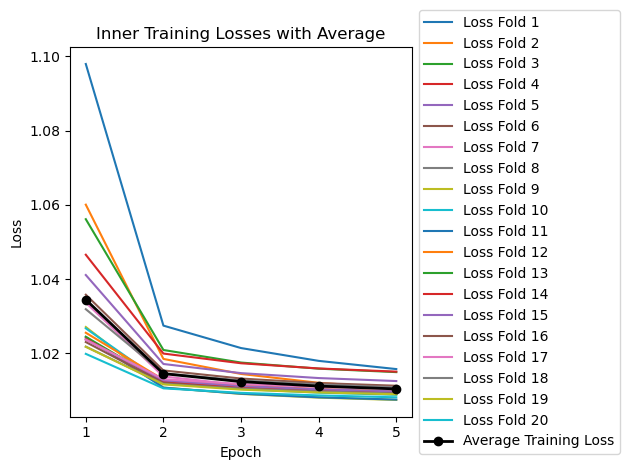

In [197]:


## plot training losses for each inner loop
plot_inner_training_losses(train_losses_all)

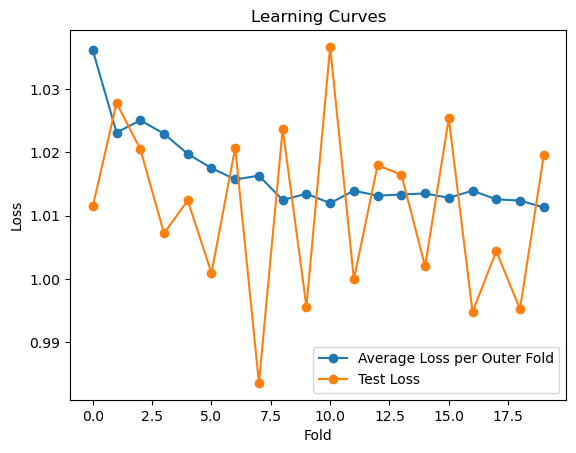

In [195]:
## plot learning curves (average over all folds)
plot_learning_curves(train_losses_all, test_losses_all)

In [ ]:
## save first version of gru (aviod long training time of gru)
final_model.save('../models/my_gru.h5')

## testing 

## Timestamp for '2025-01-01'
date = pd.Timestamp('2025-01-01').toordinal()

genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', 'Others']

my_samples = []
for i in range(20):
    one_hot_encoding = [0] * 20  
    one_hot_encoding[i] = 1  
    sample = [date] + one_hot_encoding  ## Combine the timestamp with the one-hot encoding
    my_samples.append(sample)

## Display the samples
for sample in my_samples:
    print(sample)

# Convert the list to a NumPy array
my_sample_np = np.array(my_sample)

# Drop the first column (timestamp or ID) and keep the features (genres)
my_sample_features = my_sample_np

# Apply the same StandardScaler used during training
my_sample_scaled = scaler.transform(my_sample_features)

# Initialize an empty list to store predictions
predictions = []

# Loop through each sample (predict for each row independently)
for i in range(my_sample_scaled.shape[0]):
    sample = my_sample_scaled[i].reshape(1, 1, -1)  # Reshape for GRU input (1 sample, 1 timestep, features)
    prediction = model.predict(sample)
    predictions.append(prediction[0][0])

# Convert predictions to NumPy array for easier plotting
predictions = np.array(predictions)

# Plot the predictions against the genre names (x-axis should represent genres)
plt.plot(genres[:len(predictions)], predictions, marker='o', label="Predictions")
plt.xlabel('Genre')
plt.ylabel('Predicted Value')
plt.title('Predictions for Different Genres')
plt.xticks(rotation=45)  # Rotate genre labels for better readability
plt.legend()
plt.tight_layout()
plt.show()


# Generate monthly timestamps from '2025-01-01' to '2025-12-01'
dates = pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')  # 'MS' is Month Start frequency

# Convert the dates to their ordinal format
ordinal_dates = dates.to_series().apply(lambda x: x.toordinal()).tolist()

# One-hot encoding for "Children's Animation"
one_hot_encoding = [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Create a list of samples: each sample contains the ordinal timestamp followed by the one-hot encoding
my_sample = [[ordinal] + one_hot_encoding for ordinal in ordinal_dates]

# Display the samples
for samples in my_sample:
    print(samples)

# Convert the list to a NumPy array
my_sample_np = np.array(my_sample)

# Extract the first column (timestamp) to map back after prediction
timestamps = my_sample_np[:, 0]

# Convert timestamps to ordinal format and map them back to datetime after prediction
timestamps_dates = [pd.to_datetime(pd.Timestamp.fromordinal(int(x))) for x in timestamps]

# Drop the first column (timestamp or ID) and keep the features
my_sample_features = my_sample_np

# Apply the same StandardScaler used during training
my_sample_scaled = scaler.transform(my_sample_features)

# Initialize an empty list to store predictions
predictions = []

# Loop through each sample (predict for each row independently)
for i in range(my_sample_scaled.shape[0]):
    sample = my_sample_scaled[i].reshape(1, 1, -1)  # Reshape for GRU input (1 sample, 1 timestep, features)
    prediction = model.predict(sample)
    predictions.append(prediction[0][0])

# Convert predictions to NumPy array for easier plotting
predictions = np.array(predictions)

# Plot the predictions against the original timestamps
plt.plot(timestamps_dates, predictions, marker='o', label="Predictions")
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Predicted Value')
plt.title('Predictions Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()